# SHAP Values: Optimized GP Scikit-Learn model

In [1]:
# Import needed libraries and modules
from codecarbon import EmissionsTracker
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.pipeline import Pipeline
import json
import shap

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

In [2]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

##### SETTINGS #####
PC_Features = True
Random_Seed = 82024
K_Folds = 10
Max_Iterations = 200
Example_Index = 55
####################

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Separate integer from categorical features
int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

In [3]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Load best model parameters
with open('../3-GP-Optimization/params/scikit-params.json') as f:
    best_parameters = json.load(f)

# Kernel setup
len_scale = best_parameters.pop('length_scale')
nu = best_parameters.pop('nu')
Kernels = {
    'rbf': RBF(length_scale=len_scale),
    'matern': Matern(length_scale=len_scale, nu=nu),
}
best_parameters['kernel'] = Kernels[best_parameters['kernel']]

# Create model
model = GaussianProcessClassifier(**best_parameters)

# Define pipeline depending on whether PCA is requested or not
if PC_Features:
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=12)),
        ('GP-classifier', model)
    ]
else:
    steps = [
        ('preprocessor', preprocessor),
        ('GP-classifier', model)
    ]
    
pipeline = Pipeline(steps)

# Train model
trained_model = pipeline.fit(X, y)

In [4]:
# ---------------------------------------------------------------------------- #
#                                  SHAP Values                                 #
# ---------------------------------------------------------------------------- #

# Sample
X100 = shap.utils.sample(X, 100)

# Calculate SHAP values
explainer = shap.Explainer(trained_model.predict, X100)
shap_values = explainer(X)

PermutationExplainer explainer: 298it [02:18,  2.02it/s]                         


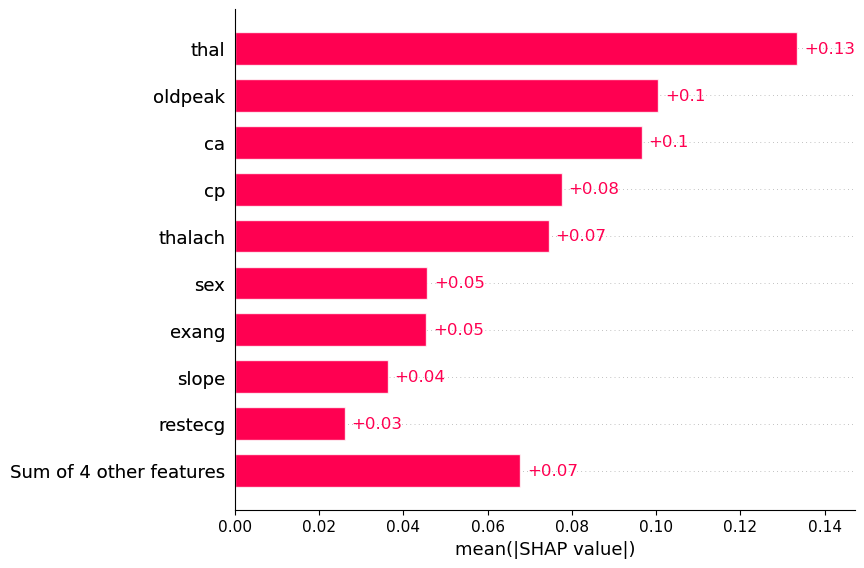

In [5]:
# Vizualize
shap.plots.bar(shap_values)

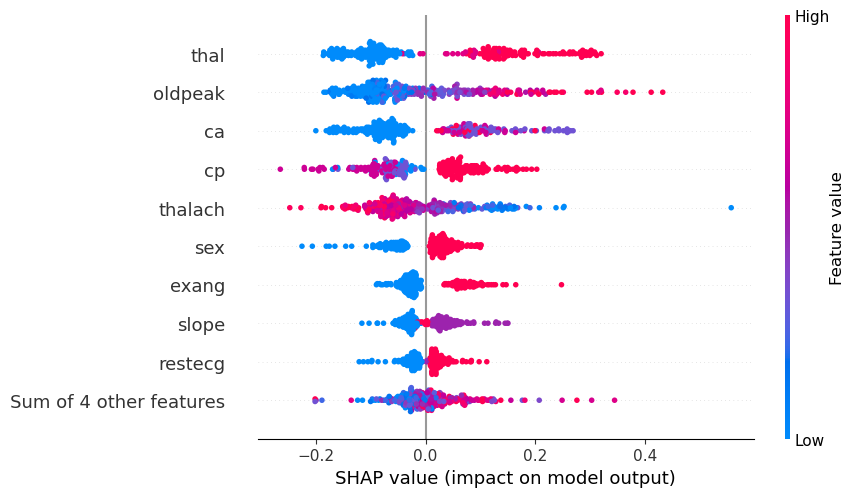

In [6]:
shap.plots.beeswarm(shap_values)